# Environment Preparation

#### Importing modules

In [41]:
import os
import pandas as pd; pd.set_option('max_colwidth', None)
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime
from IPython.display import clear_output as co

from sklearn.utils import all_estimators
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report as cr, confusion_matrix as cm
from sklearn.model_selection import (train_test_split as tts,
                                     KFold, RepeatedKFold,
                                     StratifiedShuffleSplit, StratifiedKFold,
                                     GroupKFold, GroupShuffleSplit,
                                     cross_val_score as cvs, cross_validate as CV,
                                     learning_curve as lc, validation_curve as vc)

from Classification import Classifier#, plot_lc_model_comparison
from CategoricalSampler import target_categorical_distribution, simetrical_categorical_sampler, tts_categorical

undersample = RandomUnderSampler(sampling_strategy='majority')
classifiers = dict(all_estimators('classifier'))

gkf = GroupKFold(n_splits=3)
gss = GroupShuffleSplit(n_splits=3, test_size=0.3, train_size=0.1, random_state=None)

#### Defining functions

In [1134]:
# city = top_cities[0]
class category_scorer:
    
    def __init__(
        self, ctgr_col=None,
        models=['RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier'],
        scoring=[
        'accuracy',
        'f1', 'f1_macro',
        'precision', 'precision_macro',
        'recall', 'recall_macro',
        ]
    ):
        self.name='category_scorer'
        self.ctgr_col = ctgr_col
        self.models = models
        self.scoring = scoring

    def set_split_params(self, key_col, n_splits=5, train_size=0.8, test_cls_prct=1, random_state=0, method='minority prct', prct=1, verbose=0):
        self.n_splits=n_splits
        self.train_size = train_size
        self.test_cls_prct = test_cls_prct
        self.random_state = random_state
        self.key_col = key_col
        self.method = method
        self.prct = prct
        self.verbose = verbose

    
    def SimetricalSplit(self, _x, _y):
        x, y = simetrical_categorical_sampler(
            _x, _y, col=self.key_col,
            method=self.method, prct=self.prct,
            verbose=self.verbose
        )
        xt, xe, yt, ye = tts(x, y, test_size=(1-self.train_size), random_state=self.random_state, stratify=y)
        train_index = yt.index.tolist()
        test_index = ye.index.to_list()
        left_0_index = list(set(_y.index).difference(train_index).difference(test_index))
        if self.test_cls_prct is None:
            test_index += left_0_index
        else:
            n_extra_samples = round((len(ye) / 2) * (self.test_cls_prct - 1))
            replace = n_extra_samples > len(left_0_index)
            test_index += list(np.random.choice(left_0_index, n_extra_samples, replace))
        return train_index, test_index
        
    def SimetricalCategoricalSSS(self, _x, _y):
        train_indexes, test_indexes = [], []
        for i in range(self.n_splits):
            train_index, test_index = self.SimetricalSplit(_x, _y)
            train_indexes.append(train_index)
            test_indexes.append(test_index)
        return list(zip(train_indexes, test_indexes))

    def category_data(self, X, Y, ctgr):
        ctgr_msk = X[self.ctgr_col]==ctgr
        _x = X[ctgr_msk].reset_index(drop=True).copy()
        _y = Y[ctgr_msk].reset_index(drop=True).copy()
        return _x, _y
    
    def cv_scr(self, X, Y, ctgr):

        _x, _y = self.category_data(X, Y, ctgr)
        cv = self.SimetricalCategoricalSSS(_x, _y)
        ctgr_scrs = Classifier().cv_avg(self.models, _x, _y, cv, scoring=self.scoring)
        ctgr_scrs[self.ctgr_col] = ctgr
        return ctgr_scrs
    
    def categorical_cv_scr(self, X, Y, n_ctgrs=None, ctgrs=None, path=None, partial_path=None):
        if ctgrs is None:
            ctgrs = X[self.ctgr_col][Y==1].unique()
            if n_ctgrs is not None:
                ctgrs = np.random.choice(ctgrs, n_ctgrs, replace=False)
        ctgrs_scrs = []
        for i, ctgr in enumerate(ctgrs):
            co(wait=True); print(f'Evaluating category: {ctgr} - {i+1}/{len(ctgrs)}')
            ctgrs_scrs.append(self.cv_scr(X, Y, ctgr))
            if partial_path is not None: ctgrs_scrs[i].to_csv(partial_path.format(ctgr), index=True)

        scrs = pd.concat(ctgrs_scrs)
        if path is not None: scrs.to_csv(path, index=True)
        co(wait=True); print(f'Done! {len(self.models)} models cross validated with {self.n_splits} splits for {len(ctgrs)} categories in "{self.ctgr_col}" column.')
        return scrs

def model_selection_from_scores(X, Y, city_scrs, ctgr_col, selection_criteria='recall_macro'):
    city_selected = city_scrs.loc[selection_criteria].sort_values(['mean'], ascending=False).groupby(ctgr_col).first().sort_values('mean', ascending=False);
    city_cls_count = pd.concat([Y[X[ctgr_col]==city].value_counts() for city in city_selected.index], 1).T.rename(columns={0: 'class 0', 1: 'class 1'})
    city_cls_count.index = city_selected.index
    model_selection = pd.merge(city_selected, city_cls_count, on=ctgr_col)
    return model_selection

def CR_scrs(CR, metrics=['0', '1', 'macro avg']):
    cls_cols = np.array(list(CR['0'].keys()), dtype='object')
    scrs = [pd.Series([CR['accuracy']], index=['acc'])] + [pd.Series(list(CR[clss].values()), index=cls_cols+' '+clss) for clss in metrics]
    scrs = pd.concat(scrs, 0)
    return scrs.sort_index()

def recursive_feature_inclusion(x, xe, y, ye, feature_importance, max_features=5, first_feature=1, verbose=1):
    scrs_df = []
    if max_features is None or max_features > len(feature_importance): max_features = len(feature_importance) 
    max_feat_i = range(first_feature, max_features+1)
    sorted_importance = feature_importance.sort_values(ascending=False)
    for i in max_feat_i:
        if verbose: co(wait=True); print(f'Scoring model for {i}/{max_features} most important features.')
        sel_feat = sorted_importance.iloc[first_feature-1: i].index.values
        xt_s, xe_s = x[sel_feat], xe[sel_feat]
        yp_sel = model().fit(xt_s, y).predict(xe_s)
        CR = cr(ye, yp_sel, output_dict=True)
        scrs = CR_scrs(CR)
        scrs_df.append(scrs)
    scrs_df = pd.concat(scrs_df, 1).T; scrs_df.index = sorted_importance.iloc[first_feature-1: max_features].index
    return scrs_df

def rfi_dif(RFI):
    baseline_row = pd.DataFrame([[.5]*RFI.shape[1]], columns=RFI.columns, index=['baseline'])
    RFI_base = pd.concat([baseline_row, RFI], 0)
    return pd.DataFrame(np.diff(RFI_base, axis=0), index=RFI.index, columns=RFI.columns.values+' diff')
 
def plot_rfi(rfi, figsize=(6, 5.5), sort_by=None, asc=False, fig_ax=None):
    if fig_ax is None: fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
    else: fig, ax = fig_ax
    data = rfi.copy()
    if sort_by is not None: data = rfi.sort_values(sort_by, ascending=asc)
    data.plot(marker='o', ax=ax)
    ax.set_xticks(range(len(rfi)))
    ax.set_xticklabels(rfi.index, rotation=90)
    ax.set(title='Recursive feature inclusion', xlabel='Feature', ylabel='Evaluation')
    if fig_ax is None: plt.show()

def recursive_rfi(
    xt, xe, yt, ye, feature_importance,
    n_iter=5, sort_criteria='recall diff',
    max_features=None, first_feature=1,
    plot=True, plot_full=True,
    plot_cols=np.array(['acc', 'recall macro avg', 'precision macro avg'], dtype='object'),
    sort_rfi=False, sort_dif=False,
    figsize=(12, 6),
    scrs_path=None,
    plot_path=None
):
    n_feats = len(feature_importance)
    rank = range(1, n_feats+1)
    scrs = []
    for i in range(n_iter):
        if plot and not plot_full: co(wait=True)
        print(f'Recursive feature inclusion for iteration: {i+1}/{n_iter}')
        RFI = recursive_feature_inclusion(xt, xe, yt, ye, feature_importance, max_features, first_feature, verbose=0)
        RFI_dif = rfi_dif(RFI)
        iter_data = pd.concat([RFI, RFI_dif], 1).sort_values(sort_criteria, ascending=False)
        iter_data['iter'] = i+1; iter_data['rank'] = rank
        scrs.append(iter_data)
        feature_importance = RFI_dif[sort_criteria]

        if plot:
            fig, ax = plt.subplots(1, 2, figsize=figsize, tight_layout=True)            
            plot_rfi(RFI[plot_cols], sort_by=(sort_criteria if sort_rfi else None), fig_ax=(fig, ax[0]))
            plot_rfi(RFI_dif[plot_cols+' diff'], sort_by=(sort_criteria if sort_dif else None), fig_ax=(fig, ax[1]))
            plt.show()
            if plot_path is not None:
                try: os.mkdir(plot_path)
                except: None
                plt.savefig(plot_path+f'iter-{i}.jpg')

    scrs =  pd.concat(scrs)
    if scrs_path is not None: scrs.to_csv(scrs_path, index=True)
    return scrs

# Data loading and feature/target definitions

In [4]:
#### Loading prepared data
data = pd.read_csv('data/grades/5th_grade.csv', index_col=0)
data.drop('ID_ALUNO', 1, inplace=True)

#### Loading Adapted Data Dictionaries
data_path = '/Users/luisr/Desktop/Repositories/Data/saep/CSV/{}'
grades = [5,9,3]; dict_filenames = [f'dicionario {i}ano.csv' for i in grades]
dicts = {grade: pd.read_csv(data_path.format(filename)).set_index('questão') for grade, filename in zip(grades, dict_filenames)}

#### Defining targets corresponding to each student grade
targets = { # Abandonment
    5: 'TX_RESP_Q049',
    9: 'TX_RESP_Q050',
    12: 'TX_RESP_Q044',
}
rep_targets = { # Reproval cols
    5: 'TX_RESP_Q048',
    9: 'TX_RESP_Q049',
    12: 'TX_RESP_Q043'
}
grade = 5
target = targets[grade]
rep_target = rep_targets[grade]

#### List different types of features
ids = data.columns[:10].tolist()
questions = data.columns[10:64].tolist()
grades = data.columns[64:].tolist()

---
# DATA TRANSFORMATION

### 2.2.1. Target Variable Classes Transformation


Obs: Last label represent missing values (Label 3)

In [5]:
def binary(Y, out, replace):
    # 1. Droping rows where the target variable is missing 
    # 2. Target variable conversion to binary
    labels = list(replace.keys())
    label_map = lambda label: (replace[label] if label in labels else label)
    return Y[Y.isin(out)==False].map(label_map)

### Defining X and Y

In [6]:
Y = binary(data[target].copy(), out=[3], replace={2: 1})
X = data.loc[Y.index].drop(target, 1)

Y.value_counts() # Binary classes count in target variable

0    397232
1     50087
Name: TX_RESP_Q049, dtype: int64

### MISSING VALUES STRATEGY

In [7]:
for grade in grades:
    X[grade].fillna(X[grade].mean(), inplace=True) # Filling missing values with variable mean for 'grades' columns

# CLASSIFICATION MODELING

In [9]:
models = [
    'RandomForestClassifier', 'RidgeClassifier', 'RidgeClassifierCV',
    'LinearDiscriminantAnalysis', 'AdaBoostClassifier', 'ExtraTreesClassifier',
    'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 
    'DecisionTreeClassifier', 'LinearSVC', 'LogisticRegression',
    'LogisticRegressionCV', 'BaggingClassifier'
]

In [11]:
ctgr_col = 'ID_MUNICIPIO'
key_col = 'ID_TURMA'     # Categorical column for stratified undersampling
n_splits = 11             # N° of splits for cross validation
train_size = 0.8         # Training proportion of undersampled data (undersampling method defined below)
test_cls_prct = None        # Testing class proportion (test_0/test_1)
random_state = 0
method = 'minority prct' # Undersampling method per key_col category
prct = 3                 # Training class proportion per key_col category (train_0/train_1) (Fixed)
n_ctgrs = None
ctgrs = None

In [26]:
ctgr_scorer = category_scorer(ctgr_col, models)
ctgr_scorer.set_split_params(key_col, n_splits, train_size, test_cls_prct, random_state, method, prct, verbose=0)

In [112]:
# Defining missing categories to score from score files folder.
scored_cities = np.array([file.split('.')[0] for file in os.listdir('scores/'+ctgr_col+'/')], dtype='int64')
Y_ctgrs = X[ctgr_col][Y==1].unique()
# ctgrs = set(Y_ctgrs).difference(scored_cities)

In [27]:
city_scrs = ctgr_scorer.categorical_cv_scr(X, Y, n_ctgrs=None, ctgrs=None, path='scores/'+ctgr_col+'.csv', partial_path='scores/'+ctgr_col+'/{}.csv')

Done! 13 models cross validated with 11 splits for 1009 categories in "ID_MUNICIPIO" column.


#### Reloading city category scores

In [1089]:
path = 'scores/'+ctgr_col+'/'
city_scrs = pd.concat([pd.read_csv(path+file, index_col=0) for file in os.listdir(path)])

In [1096]:
selection_criteria = 'recall_macro'
model_selection = model_selection_from_scores(X, Y, city_scrs, ctgr_col, selection_criteria); model_selection[model_selection['class 1']>10].head()

,mean,var,model,class 0,class 1
ID_MUNICIPIO,,,,,
65,0.806452,0.027349,ExtraTreesClassifier,63,12
49,0.758600,0.012762,RidgeClassifierCV,188,17
187,0.755155,0.009323,LogisticRegression,33,19
697,0.741775,0.014284,DecisionTreeClassifier,108,16
412,0.736043,0.009224,DecisionTreeClassifier,54,13


---
# Analysing individual city

In [1151]:
ctgr = 49
modelname = model_selection.loc[ctgr, 'model']
model = classifiers[modelname]
model_selection.iloc[ctgr]

mean                 0.728826
var                0.00782744
model      LogisticRegression
class 0                   191
class 1                    22
Name: 77, dtype: object

### Classification report

In [1153]:
ctgr_col = 'ID_MUNICIPIO'
key_col = 'ID_TURMA'     # Categorical column for stratified undersampling
n_splits = 7             # N° of splits for cross validation
train_size = 0.8         # Training proportion of undersampled data (undersampling method defined below)
test_cls_prct = None        # Testing class proportion (test_0/test_1)
random_state = 0
method = 'minority prct' # Undersampling method per key_col category
prct = 3           # Training class proportion simetric per key_col category (train_0/train_1) (Fixed)

ctgr_scorer = category_scorer(ctgr_col, models)
ctgr_scorer.set_split_params(key_col, n_splits, train_size, test_cls_prct, random_state, method, prct, verbose=0)
_x, _y = ctgr_scorer.category_data(X, Y, city)

train_index, test_index = ctgr_scorer.SimetricalSplit(_x, _y)
xt, yt = _x.loc[train_index], _y.loc[train_index]
xe, ye = _x.loc[test_index], _y.loc[test_index]

model_fit = model().fit(xt, yt)
yp = model_fit.predict(xe)

print(cr(ye, yp))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       148
           1       0.00      0.00      0.00         3

    accuracy                           0.83       151
   macro avg       0.49      0.43      0.45       151
weighted avg       0.96      0.83      0.89       151



### Feature Importance

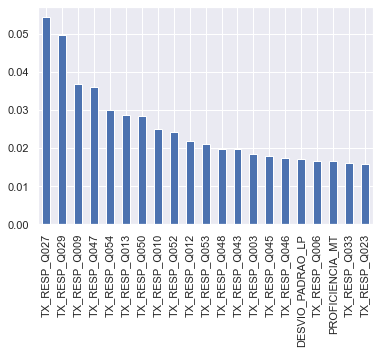

In [974]:
fi = pd.Series(model_fit.feature_importances_, index=xt.columns).sort_values(ascending=False)
fi.head(21).plot.bar()

### Recursive feature inclusion

In [ ]:
feature_importance = fi
n_iter = 20
sort_criteria = 'recall macro avg diff'

rec_rfi = recursive_rfi(
    xt, xe, yt, ye, feature_importance,
    n_iter, sort_criteria,
    max_features=None, first_feature=1,
    plot=True, plot_full=False,
    plot_cols=np.array(['acc', 'recall macro avg', 'precision macro avg'], dtype='object'),
    sort_rfi=False, sort_dif=False,
    scrs_path=f'scores/recursive_rfi_{city}.csv',
    plot_path=f'plots/recursive_rfi/{city}/'
)

In [1050]:
ranks = pd.concat([rec_rfi.loc[col].set_index('iter')['rank'].rename(col) for col in feature_importance.index], 1)

(0.0, 66.85)

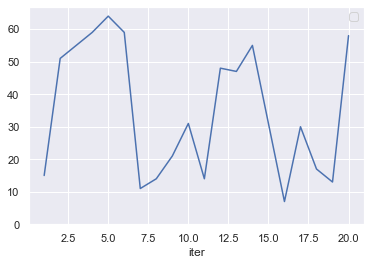

In [1088]:
ranks.T.sample(1).T.plot(); plt.legend([]); plt.ylim(0)